In [1]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
batch_size = 64

transform = transforms.ToTensor()

trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=batch_size)

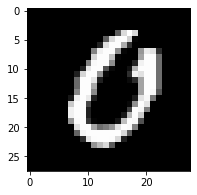

In [3]:
dataIter = iter(trainLoader)
images, labels = dataIter.next()
images = images.numpy()

# 1 ảnh mẫu trong tập dữ liệu
img = np.squeeze(images[0])
fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Z_dim = 100 # chiều của noise z
img_dim = 784 # 28x28

# Mô hình của Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, img_dim),
            nn.Sigmoid()
        )
          
    def forward(self, input):
        return self.model(input)

# Mô hình của Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

# Tối ưu

In [7]:
D = Discriminator().to(device)
G = Generator().to(device)


# Sử dụng Adam optimizer
lr = 0.002

g_opt = opt.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_opt = opt.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Mô hình

In [8]:
print(D)
print(G)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [9]:
# Hiển thị ảnh
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Huấn luyện

Epoch:1,   G_loss:1.4223039150238037,    D_loss:1.0557948350906372


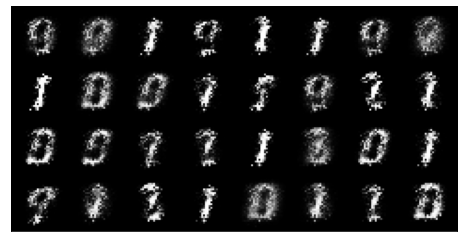

Epoch:2,   G_loss:1.7868633270263672,    D_loss:0.811189591884613


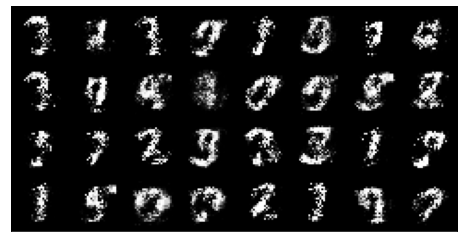

Epoch:3,   G_loss:2.0765221118927,    D_loss:0.8817436695098877


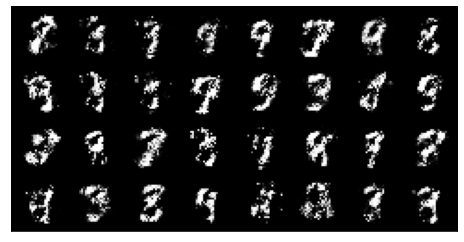

Epoch:4,   G_loss:1.7779687643051147,    D_loss:0.910767138004303


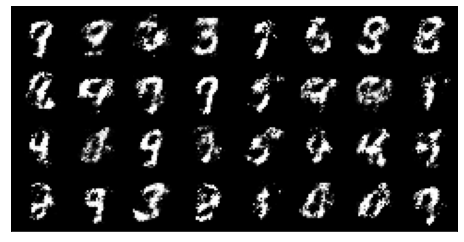

Epoch:5,   G_loss:1.1720061302185059,    D_loss:1.1136503219604492


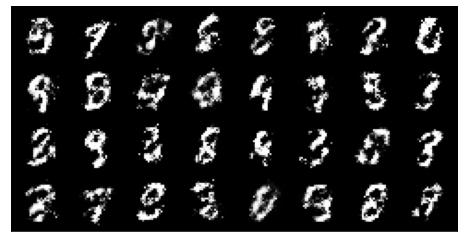

Epoch:6,   G_loss:2.2106773853302,    D_loss:0.7449617385864258


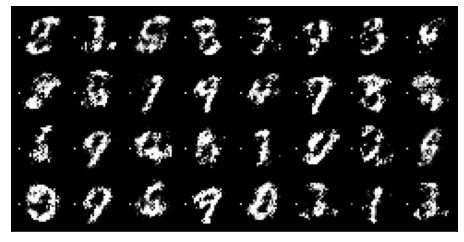

Epoch:7,   G_loss:2.500713348388672,    D_loss:1.0019489526748657


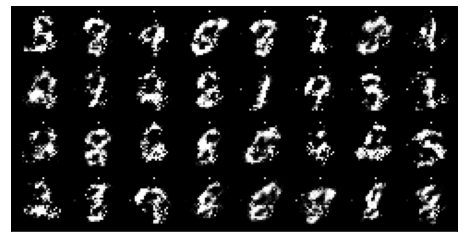

Epoch:8,   G_loss:1.9038171768188477,    D_loss:0.9295862913131714


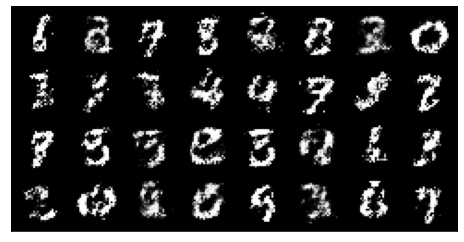

Epoch:9,   G_loss:1.1636295318603516,    D_loss:1.044128656387329


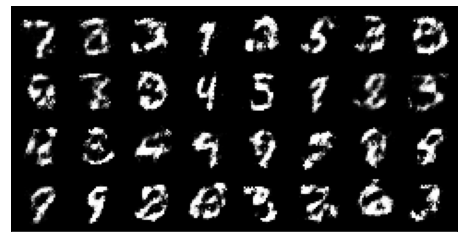

Epoch:10,   G_loss:1.5423650741577148,    D_loss:0.9127118587493896


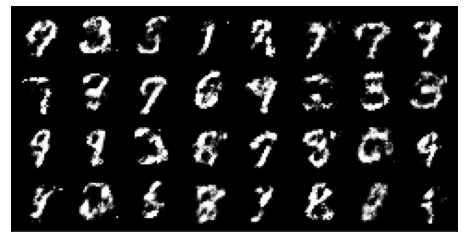

Epoch:11,   G_loss:1.2926814556121826,    D_loss:0.9095180034637451


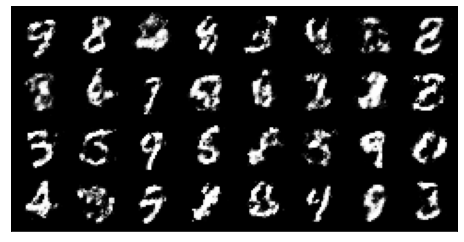

Epoch:12,   G_loss:1.4500274658203125,    D_loss:0.9325550198554993


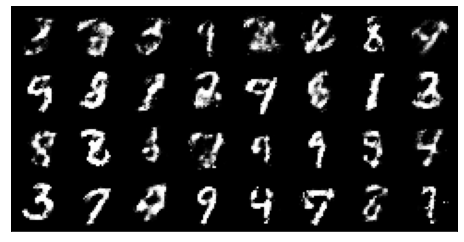

Epoch:13,   G_loss:1.5221589803695679,    D_loss:0.8216733336448669


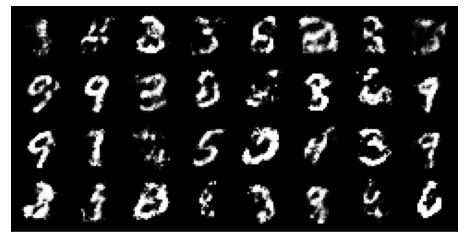

Epoch:14,   G_loss:1.6013919115066528,    D_loss:0.8745529651641846


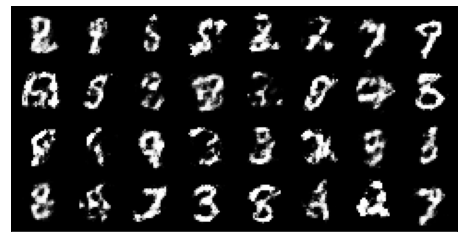

Epoch:15,   G_loss:1.8392329216003418,    D_loss:0.8544159531593323


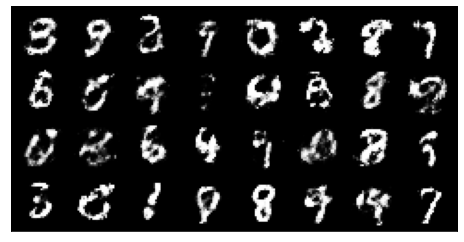

Epoch:16,   G_loss:1.7804522514343262,    D_loss:0.8395171761512756


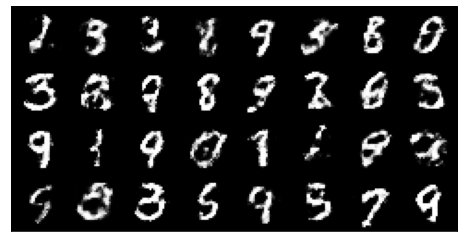

Epoch:17,   G_loss:1.8017823696136475,    D_loss:0.917841374874115


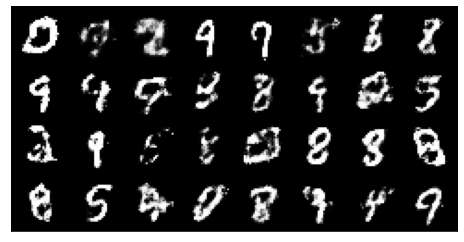

Epoch:18,   G_loss:2.261368989944458,    D_loss:0.7731102705001831


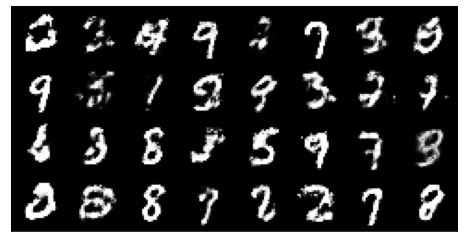

Epoch:19,   G_loss:1.7985578775405884,    D_loss:0.7037005424499512


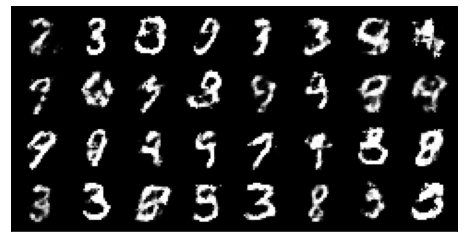

Epoch:20,   G_loss:2.812626838684082,    D_loss:0.6525892615318298


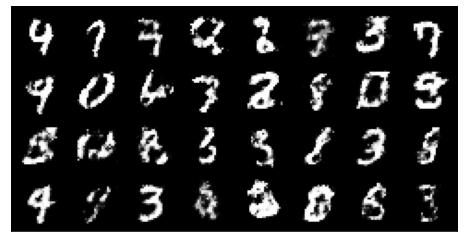

In [10]:
losses = []
epoch_num = 20

for epoch in range(epoch_num):
    G_loss_run = 0.0
    D_loss_run = 0.0
    
    for i, data in enumerate(trainLoader):
        X, _ = data
        X = X.view(X.size(0), -1).to(device)
        mb_size = X.size(0)
        one_labels = torch.ones(mb_size, 1).to(device)*0.9
        zero_labels = torch.zeros(mb_size, 1).to(device)

#       TRAIN DISCRIMINATOR        
#       Sinh noise z
        z = torch.randn(mb_size, Z_dim).to(device)
        
        D_real = D(X) # Discriminator cho ảnh thật
        D_fake = D(G(z)) # Discriminator cho ảnh giả
        
#       Loss của Discriminator với ảnh thật
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
#       Loss của Discriminator với ảnh giả
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
#       Loss của Discriminator tổng cộng
        D_loss = D_real_loss + D_fake_loss
#       backprop
        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()

#       TRAIN GENERATOR
#       Sinh noise z
        z = torch.randn(mb_size, Z_dim).to(device)
#       Discriminator cho ảnh giả
        D_fake = D(G(z))
#       Generator loss
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
#       backprop
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()

    
    losses.append((D_loss.item(), G_loss.item()))
#   Với mỗi epoch in ra loss và sample
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch+1, G_loss, D_loss))       
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28).cpu()
    imshow(samples)

Sơ đồ training loss

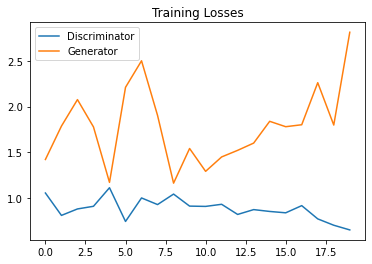

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()